In [2]:
from bs4 import BeautifulSoup
import time
from selenium import webdriver
import random
from selenium.webdriver.common.proxy import Proxy, ProxyType
from selenium.webdriver.support.select import Select
from fake_useragent import UserAgent
import pickle
import pandas as pd
import numpy as np


%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns

import copy

In [44]:
def get_prox_list():
    '''get proxy list from free proxy list website and return the list'''
    driver = webdriver.Chrome()
    try:
        driver.get('https://free-proxy-list.net/')
        proxies = []
        entries_fr = Select(driver.find_element_by_name('proxylisttable_length'))
        entries_fr.select_by_value('80')
        for i in range(4):
            rows = driver.find_elements_by_class_name('odd')
            for row in rows:
                cells = row.find_elements_by_tag_name('td')
                if cells[-2].text == 'no':
                    continue
                else:
                    proxies.append(cells[0].text+':'+cells[1].text)
            rows = driver.find_elements_by_class_name('even')
            for row in rows:
                cells = row.find_elements_by_tag_name('td')
                if cells[-2].text == 'no':
                    continue
                else:
                    proxies.append(cells[0].text+':'+cells[1].text)   
            driver.find_element_by_xpath("//a[contains(text(),'Next')]").click()
        rows = driver.find_elements_by_class_name('odd')
        for row in rows:
            cells = row.find_elements_by_tag_name('td')
            if cells[-2].text == 'no':
                continue
            else:
                proxies.append(cells[0].text+':'+cells[1].text)
        rows = driver.find_elements_by_class_name('even')
        for row in rows:
            cells = row.find_elements_by_tag_name('td')
            if cells[-2].text == 'no':
                continue
            else:
                proxies.append(cells[0].text+':'+cells[1].text)
    except:
        print("didn't retrieve any proxy, please use the backup")
    driver.quit()
    return proxies
    

In [3]:
def set_proxy_driver(proxy):
    '''start a chrome driver with a given proxy and set a fake agent'''
    co = webdriver.ChromeOptions()
    co.add_argument("log-level=3")
    #co.add_argument("--headless")
    ua = UserAgent()
    user_agent='user-agent='+ ua.random
    co.add_argument(user_agent)
    
    prox = Proxy()
    prox.proxy_type = ProxyType.MANUAL
    prox.http_proxy = proxy
    prox.socks_proxy = proxy
    prox.ssl_proxy = proxy

    capabilities = webdriver.DesiredCapabilities.CHROME
    prox.add_to_capabilities(capabilities)
    #driver = webdriver.Chrome(desired_capabilities=capabilities)
    driver = webdriver.Chrome(chrome_options=co, desired_capabilities=capabilities)
    return driver

In [58]:
def rotate_proxy(proxy_list = proxy_list, proxy_list_bk=proxy_list_bk):
    '''Use proxy from proxy list. If the list is empty or there's no list, 
    it will use the proxy from the backup lis.
    Return the last proxy and remove it from the list
    '''
    if not proxy_list:
        proxy_list = proxy_list_bk.copy()
    return proxy_list.pop()
    

In [234]:
proxy_list = get_prox_list()

In [235]:
proxy_list_bk = proxy_list.copy()
len(proxy_list)

106

In [238]:
def get_webpage(position_str, click):
    '''click the 'more' in the page with the jobs on the input role until it is not clickable.
    return the webpage.
    it will click the amount of times as specified. 
    After that, if the number of entry doesn't increase after additional click, it will return the 
    whole webpage.
    '''
    driver = set_proxy_driver(proxy_list.pop())
    url = 'https://angel.co/salaries/'+position_str
    driver.get(url)
    time.sleep(3)
    for i in range(click):
        print('click ', i+1)
        driver.find_elements_by_class_name('g-feed_more')[-1].click()
        time.sleep(1+random.random()*3)
        #print(len(driver.find_elements_by_class_name('g-feed_more')))
        #$print(driver.find_elements_by_class_name('g-feed_more')[-1].is_displayed())
    webpage = driver.page_source
    soup = BeautifulSoup(webpage, 'lxml')
    company_set = soup.find_all('div', {'class': 'startup-row section'})
    record = len(company_set)
    count = click
    while True:
        driver.find_elements_by_class_name('g-feed_more')[-1].click()
        webpage = driver.page_source
        soup = BeautifulSoup(webpage, 'lxml') 
        company_set = soup.find_all('div', {'class': 'startup-row section'})
        if len(company_set) > record:
            record = len(company_set)
            count += 1
            print(count, record)
            time.sleep(1+random.random()*5)
        else:
            break
    webpage = driver.page_source
    driver.quit()    
    return webpage


#Starting from webpage containing datascience jobs urls as a seed. 
#Then got to those company webpage and job webpage to get additinoal job webpages.
#webpage_creative_director = web  #webpage contains all job list with creatie director title

webpage_data_scientist = get_webpage('data-scientist', 67)

click  1
click  2
click  3
click  4
click  5
click  6
click  7
click  8
click  9
click  10
click  11
click  12
click  13
click  14
click  15
click  16
click  17
click  18
click  19
click  20
click  21
click  22
click  23
click  24
click  25
click  26
click  27
click  28
click  29
click  30
click  31
click  32
click  33
click  34
click  35
click  36
click  37
click  38
click  39
click  40
click  41
click  42
click  43
click  44
click  45
click  46
click  47
click  48
click  49
click  50
click  51
click  52
click  53
click  54
click  55
click  56
click  57
click  58
click  59
click  60
click  61
click  62
click  63
click  64
click  65
click  66
click  67


In [239]:
def scrape_from_salary_job(webpage_file):
    '''take a html text file or selenium source page and return a list of dictionaries. 
    The dictionary keys include company name, company job url(webpage contain all job opening info,
    company tagline(in case want to do any NPL later),
    list of tags (The first element is location)
    '''
    all_records = []
    soup = BeautifulSoup(webpage_file, 'lxml')
    companies = soup.find_all('div', {'class': 'startup-row section'})
    for company in companies:
        row = {}
        name = company.find('div', {'class': 'name'}).text
        row['name'] = name
        company_jobs_url = 'https://angel.co' + company.find('a')['href']
        row['company_job_url'] = company_jobs_url
        tagline = company.find('div', {'class': 'tagline'}).text
        row['tagline'] = tagline
        tags=[tags_div.text for tags_div in company.find_all('div', {'class': 'tag'})]
        row['tags'] = tags
        all_records.append(row)
    return all_records

In [241]:
company_jobs = scrape_from_salary_job(webpage_data_scientist)

In [253]:
def get_job_url(company_jobs, proxy_list):
    '''visit the company job web site, return a list of dictionaries. 
    The dictionary keys include company name, company description,
    job tile, url for detailed job description
    company size and hiring pitch, location and compensation.
    '''
    count = 1
    job_list = []
    company_info = []
    job_urls = []
    scraped=[]
    driver = set_proxy_driver(proxy_list.pop())
    #go through the company jobs list, visit the url. Switching proxy for every 5 visits
    for company in company_jobs:
        name = company['name']
        count += 1
        if count%5 == 0:
            driver.quit()
            proxy = rotate_proxy(proxy_list,proxy_list_bk)
            driver = set_proxy_driver(proxy)
            driver.set_page_load_timeout(30)
        try: 
            driver.get(company['company_job_url'])
            soup = BeautifulSoup(driver.page_source, 'lxml')
        #get category info 
            job_cat= soup.find('ul', {'class': 'job-listings'}).find_all('li')
            for category in job_cat:
                jobs = category.find_all('div', {'class': 'listing-title s-grid-colSm18'})
                for job in jobs:
                    job_info = {}
                    job_info['url'] = job.find('a')['href']
                    job_urls.append(job.find('a')['href'])
                    job_info['title'] = job.find('a').text,
                    job_info['location_type'] = job.find('div', {'class': 'listing-data u-colorGray9'}).text
                    job_info['compensation'] = job.find('span', {'class': 'listing-break-middot'}).text
                    job_info['company'] = name
                    job_list.append(job_info)
        except:
            print(company['company_job_url'])
            continue
        try:
            descriptions = soup.find_all('div', {'class', 'product-description u-fontSize14 u-colorGray6'})
            company['descrption'] = [p.text for p in descriptions]
        except:
            company['descrption'] = None
            continue
        try:
            hiring_pitches = soup.find('div', {'class': 'preamble-section'}).find_all('p')
            company['hiring_pitch'] = [p.text for p in hiring_pitches]
        except:
            company['hiring_pitch'] = None
            continue
        try:
            company['size'] = soup.find('div', {'class': 'vital s-vgBottom1 tiptip'}).text
        except:
            company['size'] = None
            continue    
        #tags = soup.find('div', {'class': 'vital-icon s-vgPullLeft2 u-floatLeft fontello-tag'})
        #job_page_url.extend([tag.find('a')['href'] for tag in tags])
        #company['segments'] = [tag.find('a').text for tag in tags]
        company_info.append(company) 
        scraped.append(company['company_job_url'])
        time.sleep(random.random()*10)      
    return(job_list, company_info, job_urls, scraped)                

In [257]:
job_list, company_info, job_urls, scraped_websites = get_job_url(company_jobs[11:15], proxy_list)

In [258]:
scraped_master = set(scraped_websites)

In [261]:
def get_more_job_urls(soup):
    '''scraping more job urls from the job page, return those urls.
    '''
    try: 
        recommendation = soup.find('div', {'class', 
                                  'recommendations showcase-section u-bgGray s-vgBorderTop1'})
        more_jobs = recommendation.find_all('div', {'class', 'title u-fontSize16 u-fontWeight400'})
        more_job_urls=[]
        for each in more_jobs:
            entry = each.find('a')['href']
            more_job_urls.append(entry.split('?')[0])
    except:
        more_job_urls = []
    return more_job_urls
    

In [262]:
def parse_job_page(soup):
    record = {}
    try: 
        summary = soup.find('div', {'class':'company-summary s-grid-colSm24'})
        title, name = summary.find('h1').text.split(' at ')
        record['title'] = title
        record['name'] = name
        line = summary.find('div').text
        location, job_type = line.split(' · ')
        record['job_type'] = job_type
        city, state = location.split(', ')
        record['city'] = city
        record['state'] = state
    except:
        raise
    #get job description
    try: 
        ps = (soup.find('div', {'class': 'job-description u-fontSize14 u-colorGray6'})
         .find_all('p'))
        description = '\n'.join([p.text for p in ps])
        description = description.replace('\xa0\u200b', ' ')
        description = description.replace('\xa0', ' ')
        record['description'] = description
    except:
        print('no description')
        record['description'] = None
    #get compensation, and other information
    try: 
        div = soup.find('div',{'class',
                               'job-listing-metadata s-grid-colMd8 s-grid--preMd1 u-colorGray6 u-fontSize14'})
        meta = [item.text.strip() for item in div.find_all('div')]
        for i in range(int(len(meta)/2)):
            record[meta[i*2]] = meta[i*2+1]
    except:
        print('no meta')
        record['compensation']=None
    more_job_urls = get_more_job_urls(soup)
    return (record, more_job_urls)


In [263]:
#version with tags fixed
def parse_company_page(soup):
    record = {}
    try:
        summary = soup.find('div', {'class': 'summary'})
        record['name'] = summary.find('h1').text.strip()
        record['concept'] = summary.find('h2').text.strip()
        tags=[]
        tag_blocks = soup.find('div', {'class', 'js-market_tag_holder'}).find_all('a')
        for tag in tag_blocks:
            tags.append(tag.text)
        record['tags'] = tags
    except:
        raise
    #get size
    try:
        size = soup.find('span',{'class':'js-company_size'}).text
        record['size'] = size.strip()
    except:
        record['size'] = None
    #get product info
    try:
        product = (soup.find('div',{'class':'product_desc editable_region'})
                   .find('div',{'class':'content'}).text.strip())
        product = product.replace('… · More', '')
        record['product'] = product
    except:
        record['product'] = None
    #get funding
    try:
        fund_info = soup.find_all('div',{'class':'raised'})
        funds=[]
        for f in fund_info:
            funds.append(f.find('a').text)
        record['funds'] = funds
    except:
        record['funds'] = None
    #get number of total investors
    try:
        investors=(soup.find('div',{'data-role':'past_investor'})
                   .find('a',{'class':'view_all'}).text)
        record['investors']= investors
    except:
        record['investors'] = None
    #get current employee number
    try:
        current_employee=(soup.find('div',{'class':'section team'})
                          .find('a',{'class':'view_all'}).text)
        record['employees'] = current_employee
    except:
        record['employees'] = None
    try:
        open_jobs = (soup.
                     find('span', {'class':' jobs-tag g-tag square orange larger'}).text)
        record['open_jobs'] = open_jobs
    except:
        record['open_jobs'] = None
    return record

Scraping job pages.

In [ ]:
additional_job_urls = set()
job_records = []

In [70]:
t = len(job_urls//100)
for i in range(0, 5):
    print('Staring working on i:', i)
    url_to_scrape = job_urls[i*100:(i+1)*100]
    for url in url_to_scrape:
        if url in scraped_master:
            continue
        count += 1
        if count%5 == 0:
            driver.quit()
            if not proxy_list:
                proxy_list = get_prox_list()
            proxy = rotate_proxy(proxy_list,proxy_list_bk)
            driver = set_proxy_driver(proxy)
            driver.set_page_load_timeout(30)    
        try:
            driver.get(url)
            soup = BeautifulSoup(driver.page_source, 'lxml')
            parse_job_page(soup)
        except:
            try:
                count += 1
                driver.quit()
                proxy = rotate_proxy(proxy_list=proxy_list)
                driver = set_proxy_driver(proxy)
                driver.get(url)
                soup = BeautifulSoup(driver.page_source, 'lxml')
                parse_job_page(soup)
            except:
                print('cannot reach the site', url)
                continue
        record, more_job_urls = parse_job_page(soup)
        record['url'] = url
        job_records.append(record)
        additional_job_urls = additional_job_urls.union(more_job_urls)
        print(record['name'], record['title'])
        pagename = 'webpage/'+url.split('/')[-1]+'.pkl'
        with open(pagename,'wb') as f:
            pickle.dump(driver.page_source, f)
        time.sleep(random.random()*10)
        scraped_master.add(url)
    session = (job_records, additional_job_urls, scraped_master)
    session_name = 'job_details_session_'+str(i)+'.pkl'
    with open(session_name, 'wb') as picklefile:
        pickle.dump(session, picklefile)

Staring working on i: 1
Discord Senior Software Engineer - Frontend
Origin Director of Hardware Engineering
cannot reach the site https://angel.co/aurora-insight/jobs/318189-data-scientist
CusJo Software Engineer - Front End Developer
Welendus Accountant
Staring working on i: 2
ESSI Integrated Technologies Communications Manager
CusJo Artificial Intelligence / Machine Learning / Deep Learning Expert
Tile Principal Android Engineer
Covee Network Statistician
Birds.ai Full Stack Developer
CognitionX Consulting Director
Starcom Information Technology ETL (SSIS) Developer for product Development profile
Aurora Insight Data Product Manager
Staring working on i: 3
cannot reach the site https://angel.co/lisk/jobs/377518-community-manager-uk-market-at-lisk
Lift Director, Product Management
People.ai Senior Backend Software Engineer - Python (AI/ML Enterprise SaaS)
cannot reach the site https://angel.co/lisk/jobs/377511-community-manager-germany-market-at-lisk
cannot reach the site https://ange

In [65]:
driver.quit()

In [71]:
session = (job_records, additional_job_urls, scraped_master)
session_name = 'job_details_session.pkl'
with open(session_name, 'wb') as picklefile:
    pickle.dump(session, picklefile)

Also scrape the job urls in addtional_job_urls and the urls that weren't scraped in the previous round. Should have wrote a function to avoid the duplicate code. 

In [76]:
additional_job_urls_working_list = list(additional_job_urls)

In [145]:
#updatd one for job details scraping
t = len(additional_job_urls_working_list//100)
count = 0
for i in range(0, 2):
    print('Staring working on i:', i)
    url_to_scrape = list(additional_job_urls_working_list)[i*100:(i+1)*100]
    for url in url_to_scrape:
        if url in scraped_master:
            continue
        count += 1
        print('scraping ', url)
        if count%5 == 0:
            driver.quit()
            if not proxy_list:
                try:
                    proxy_list = get_prox_list()
                except:
                    proxy_list = proxy_list_bk.copy()
            proxy = rotate_proxy(proxy_list,proxy_list_bk)
            driver = set_proxy_driver(proxy)
            driver.set_page_load_timeout(30)    
        try:
            driver.get(url)
            soup = BeautifulSoup(driver.page_source, 'lxml')
            parse_job_page(soup)
        except:
            try:
                count += 1
                driver.quit()
                proxy = rotate_proxy(proxy_list=proxy_list)
                driver = set_proxy_driver(proxy)
                driver.get(url)
                soup = BeautifulSoup(driver.page_source, 'lxml')
                parse_job_page(soup)
            except:
                print('cannot reach the site', url)
                continue
        record, more_job_urls = parse_job_page(soup)
        record['url'] = url
        job_records.append(record)
        additional_job_urls = additional_job_urls.union(more_job_urls)
        print(record['name'], record['title'])
        pagename = 'webpage/'+url.split('/')[-1]+'.pkl'
        with open(pagename,'wb') as f:
            pickle.dump(driver.page_source, f)
        time.sleep(random.random()*5)
        scraped_master.add(url)
    session = (job_records, additional_job_urls, scraped_master)
    session_name = 'job_details_session_b'+str(i)+'.pkl'
    with open(session_name, 'wb') as picklefile:
        pickle.dump(session, picklefile)

Staring working on i: 0
scraping  https://angel.co/great-jones/jobs/355960-sales-operations-lead
cannot reach the site https://angel.co/great-jones/jobs/355960-sales-operations-lead
scraping  https://angel.co/blacksky-a-subsidiary-of-spaceflight-industries/jobs/294106-platform-geospatial-engineer
BlackSky (a subsidiary of Spaceflight Industries) Platform GeoSpatial Engineer
scraping  https://angel.co/lawtrades/jobs/380749-account-executive
LawTrades Account Executive
scraping  https://angel.co/tell-em-3/jobs/288633-cfo
Tell Em' CFO
scraping  https://angel.co/ubble-ai/jobs/335506-software-development-engineer-full-stack
ubble.ai Software Development Engineer (Full-stack)
scraping  https://angel.co/starcom-information-technology/jobs/367046-freshers
Starcom Information Technology freshers
scraping  https://angel.co/whereto/jobs/346247-vp-of-engineering
WhereTo VP of Engineering
scraping  https://angel.co/pathai/jobs/329274-senior-software-engineer-platform
PathAI Senior Software Engineer

In [147]:
session = (job_records, additional_job_urls, scraped_master)
session_name = 'job_details_session_b.pkl'
with open(session_name, 'wb') as picklefile:
    pickle.dump(session, picklefile)

In [146]:
len(job_records)

2061

get company page info

In [ ]:
job_urls.extend(additional_job_urls_working_list)

In [87]:
def get_company_url(job_urls_list):
    company_urls = set()
    for url in job_urls_list:
        c_url = url.split('/jobs')[0]
        company_urls.add(c_url)
    return list(company_urls)

In [83]:
company_urls = get_company_url(job_urls)

In [96]:
company_records=[]

In [189]:
t = len(company_urls//100)
count = 0
for i in range(0, 8):
    print('Staring working on i:', i)
    url_to_scrape = list(additional_company_urls)[i*100:(i+1)*100]
    for url in url_to_scrape:
        if url in scraped_master:
            continue
        count += 1
        print('scraping ', url)
        if count%5 == 0:
            driver.quit()
            if not proxy_list:
                try:
                    proxy_list = get_prox_list()
                except:
                    proxy_list = proxy_list_bk.copy()
            proxy = rotate_proxy(proxy_list,proxy_list_bk)
            driver = set_proxy_driver(proxy)
            driver.set_page_load_timeout(30)    
        try:
            driver.get(url)
            soup = BeautifulSoup(driver.page_source, 'lxml')
            record = parse_company_page(soup)
        except:
            try:
                count += 1
                driver.quit()
                proxy = rotate_proxy(proxy_list=proxy_list)
                driver = set_proxy_driver(proxy)
                driver.get(url)
                soup = BeautifulSoup(driver.page_source, 'lxml')
                record = parse_company_page(soup)
            except:
                print('cannot reach the site', url)
                continue
        #record, more_job_urls = parse_job_page(soup)
        record['url'] = url
        company_records.append(record)
        print(record['name'])
        pagename = 'webpage/company/'+url.split('/')[-1]+'.pkl'
        with open(pagename,'wb') as f:
            pickle.dump(driver.page_source, f)
        time.sleep(random.random()*5)
        scraped_master.add(url)
    session = (company_records, scraped_master)
    session_name = 'company_details_session_'+str(i)+'.pkl'
    with open(session_name, 'wb') as picklefile:
        pickle.dump(session, picklefile)

Staring working on i: 0
Staring working on i: 1
Staring working on i: 2
Staring working on i: 3
Staring working on i: 4
Staring working on i: 5
Staring working on i: 6
Staring working on i: 7


In [187]:
session = (company_records, scraped_master)
session_name = 'company_details_session_'+ t +'.pkl'
with open(session_name, 'wb') as picklefile:
    pickle.dump(session, picklefile)

Data clean up 

In [ ]:
def parse_salary(record):
    '''return lower and higher bound of salary and the currency info
    '''
    if 'Compensation' not in record:
        return (None, None, None)
    compensation = [s.replace('\n', '') for s in record['Compensation'].split('\n\n')]
    salary = compensation[0]
    salary = salary.replace('K', '000')
    salary = salary.replace('M', '000000')
    salaries = re.findall(r'\d+',salary)
    if salaries:
        salary_low = int(salaries[0])
        try:
            salary_high = int(salaries[1])
        except:
            salary_high = salary_low       
        match = re.match(r'(.)\d', salary)
        if match:
            currency = match.groups(1)[0]
        else:
            currency = None
        return (int(salary_low), int(salary_high), currency)
    else: 
        return (None, None, None)

In [ ]:
def get_salary_equity(record):
    '''get equity info
    '''
    if 'Compensation' not in record:
        return None
    compensation = [s.replace('\n', '') for s in records['Compensation'].split('\n\n')]
    salary = compensation[0]
    try:
        equity = compensation[1]
    except:
        equity = None
    return equity

In [ ]:
def get_experience(record):
    '''get the minimum experience requirement. if a few years, put a few.
    transform 'a few to mode, NA to median.
    '''
    #m = re.search('(\d)\s+year', records['description'])
    result = None
    des = record['description']
    m = re.search(r'a few years', des.lower())
    if m:
        return 'a few'
    m = re.search(r'(\d)?-?(\d+)\+?\s+year.{,60}experience', des.lower())    
    if m: 
        if m.group(1):
            result = m.group(1)
        else:
            result = m.group(2)
        return result
    m = re.search(r'experience.{,20}(\d)?-?(\d+)\+?\s+year', des.lower())
    if m: 
        if m.group(1):
            result = m.group(1)
        else:
            result = m.group(2)
    return result

In [ ]:
def has_401k(record):
    '''return whether the company has 401k
    '''
    if '401k' in record['description'].lower():
        return 1
    else:
        return 0

In [ ]:
def has_health_insurance(record):
    '''return whether the company has health insurance
    ''' 
    word_list = ['standard benefit', 'insurance', 'health benefit']
    for word in word_list:
        if word in record['description'].lower():
            return 1
    else:
        return 0

In [ ]:
def has_free_food(record):
    '''Return whether the company has stocked kitchen.
    '''
    word_list = ['lunches', 'stocked kitchen', 'pizza']
    for word in word_list:
        if word in record['description'].lower():
            return 1
    return 0 

In [ ]:
def get_education(record):
    '''return minimum education requirement
    '''
    text = record['description'].lower()
    #search for bs
    if re.search(r'\bb\.?s\.?\s+', text):
        return 'bs'
    if 'bachelor' in text:
        return 'bs'
    #search for ms
    if re.search(r'\bm\.?s\.?\s+', text):
        return 'ms'
    if 'masters' in text or "master's" in text:
        return 'ms'
    #search for phd
    if re.search(r'\bph\.?d\.?\s+', text):
        return 'phd'
    if ' doctorate' in text or ' doctoral' in text:
        return 'phd'
    #search for postdoc
    if 'postdoc' in text or 'post-doc' in text:
        return 'postdoc'
    return None

In [ ]:
#clean up the data in job_records. 
job_records_clean1=[]
for r in job_records:
    r['salary_min'], r['salary_max'], r['currency'] = parse_salary(r)
    r['equity'] = get_salary_equity(r)
    r['experience'] = get_experience(r)
    r['401k'] = has_401k(r)
    r['insurance'] = has_health_insurance(r)
    r['free_food'] = has_free_food(r)
    r['degree'] = get_education(r)
    job_records_clean1.append(r)

In [ ]:
job_df = pd.DataFrame(job_records_clean1)

Remove job with salary in ¥ or ₹. Convert the other currency to USD

In [ ]:
job_df = job_df[job_df.currency != '¥']

In [ ]:
job_df = job_df[job_df.currency != '₹']

In [ ]:
def currency_convert(row):
    salary_min = row['salary_min']
    salary_max = row['salary_max']
    if row['currency'] == '£':
        salary_min = row['salary_min'] * 1.31
        salary_max = row['salary_max'] * 1.31
    if row['currency'] == '€ ':
        salary_min = row['salary_min']  * 1.17
        salary_max  = row.salary_max * 1.17
    if row['currency'] == '₹':
        salary_min = row['salary_min'] * 0.015
        salary_max  = row['salary_max'] * 0.015
    salary_average = (salary_min + salary_max)/2
    return (salary_min, salary_max, salary_average)

Calculate the average salary offer for each job record.

In [ ]:
job_df['salary_low'], job_df['salary_high'], job_df['average_salary'] = \
zip(*job_df.apply(currency_convert, axis=1))

In [ ]:
job_df.drop(columns=['Compensation','salary_min', 'salary_max'], inplace=True)
job_df.dropna(subset=['average_salary'], inplace = True)

Convert visa support to binary variable. "Available" = 1, "Not Available" = 0

In [ ]:
visa = np.zeros((len(job_df),1), dtype='int')

visa[job_df['Visa Sponsorship'] == 'Available']=1

job_df['visa'] = visa

job_df.drop(columns='Visa Sponsorship', inplace=True)

Process company records

In [ ]:
def get_number(text):
    '''Extract number from the text and convert String format to int.
    '''
    if not text:
        return None
    m = re.search(r'\d+', text)
    if m:
        return int(m.group(0))
    else:
        return None

In [ ]:
for r in company_records:
    r['investors'] = get_number(r['investors'])
    r['employees'] = get_number(r['employees'])

In [ ]:
##get funding# and amount(this information is not used in the model though) 
def parse_funding_info(record):
    funds = record['funds']
    try: 
        number = len(funds)
        fund_clean = []
        for f in funds:
            if f == 'Unknown':
                continue 
            f= f.lstrip('$').replace(',', '')
            fund_clean.append(int(f))
        average = sum(fund_clean)/len(fund_clean)
    except:
        number = None
        average = None
    return (number, average)

In [ ]:
for r in company_records:
    r['fund_number'], r['average_funds'] = parse_funding_info(r)

In [ ]:
#fix missing value in open jobs. Reextact job openning info from saved webpage.
for r in company_records:
    if not r['open_jobs']:
        filename = 'webpage/company/' + r['url'].split('/')[-1] + '.pkl'
        with open(filename, 'rb') as f:
            page_source = pickle.load(f)
        soup = BeautifulSoup(page_source, 'lxml')
        try:
            soup.find('span', {'class':'jobs-tag-large jobs-tag g-tag square orange larger'}).text
            r['open_jobs'] = (soup
                              .find('span', {'class':'jobs-tag-large jobs-tag g-tag square orange larger'})
                              .text)
        except:
            print(r['name'], r['url'], 'not found')

In [ ]:
company_df = pd.DataFrame(company_records)

Merge job dataframe with company dataframe.

In [ ]:
job_df['name'] = job_df.name.str.strip()

In [ ]:
df = pd.merge(job_df, company_df, left_on='name', right_on ='name', how='left',suffixes=('_j', '_c') )

In [ ]:
df['open_jobs'] = df['open_jobs'].astype('int64') 

Remove outliers

In [ ]:
#Focus on small-mid size company. Remove companies that have a lot job openings
open_jobs >=60. 
df1 = df[df['open_jobs']<60].copy()

In [ ]:
#remove records with no salaries
df1 = df1[df1['currency'].notnull()]

In [ ]:
#remove large size start ups
df1 = df1[~(df1['size']=='1001-5000')]
df1 = df1[~(df1['size']=='501-1000')]

A few recored has exprience requirement 'a few years', convert to 3 years, which is the mode. And few NaN with 0

In [ ]:
df1.loc[df1['experience'] == 'a few', 'experience'] = 3

In [ ]:
df1['experience'] = df1['experience'].astype('float64')

In [ ]:
df1['experience'].fillna(0)

In [ ]:
df2 = df1.reset_index().drop(columns='index')

In [ ]:
df2.drop(columns =['name1', 'average_funds', 'fund_number', 'funds', 'url_c'], inplace=True)

Convert a list of tags into a string, separated by comma.

In [ ]:
def remove_brackets(x):
    return ','.join(x)

In [ ]:
df2['tags']=df2.tags.apply(remove_brackets)

Convert size to dummies variable.

In [ ]:
size_dummies = pd.get_dummies(df2['size'])
for col in size_dummies.columns:
    df2[('size_' + col)] = size_dummies[col]

Convert degree to dummies variable.

In [ ]:
degree_dummies = pd.get_dummies(df2['degree'])
for col in degree_dummies.columns:
    df2[('degree_' + col)] = degree_dummies[col]

In [ ]:
def split_equity(x):
    #print(x)
    if x == 'No Equity':
        return (0, 0)
    res = []
    for e in x.split('–'):
        #print(e)
        e = e.replace('%', '')
        if not e:
            e = 0
        res.append(float(e))
    return res

In [ ]:
df3 = df2.copy()

In [ ]:
df3['equity_low'], df3['equity_high'] = zip(*df3.equity.apply(split_equity))

Remove records with extreme high equity offer. Not interested in those ones 

In [ ]:
df3 = df3[df3['equity_low']<20]
df3.drop(columns = 'equity', inplace = True)

Re-extract the location information, as I notice that there can be multiple locations under on post. And the information is not consistently in the format of city, state. Merge to the dataframe. Convert all of them as dummie variables later.

In [231]:
location_list=[]
for url in all_job_urls:
    filename = 'webpage/' + url.split('/')[-1] + '.pkl'
    try:
        with open(filename, 'rb') as f:
            webpage = pickle.load(f)
        soup = BeautifulSoup(webpage, 'lxml')
        summary = soup.find('div', {'class':'company-summary s-grid-colSm24'})
        title, name = summary.find('h1').text.split(' at ')
        record['title'] = title
        record['name'] = name
        line = summary.find('div').text
        location, job_type = line.split(' · ')
        locations = ','.join(location.split(', '))
        print(locations)
        location_list.append((url, locations))
    except:
        print(url)


New York City
Berlin,New York City,Denver
San Francisco
Bengaluru
Nairobi,Remote
Singapore
Boston,Providence
San Francisco
San Diego
London
San Mateo
Amsterdam
Montreal,Toronto
London
Palo Alto
San Francisco
Palo Alto
Toronto
Remote,Remote
New York City
https://angel.co/seatgeek/jobs/302054-customer-experience-specialist-portland-or
Amsterdam
Amsterdam
San Francisco,Remote
United States,Remote
Remote
San Francisco
San Francisco
Mumbai
San Francisco,Oakland,Berkeley,Remote
Bengaluru
Hyderabad
Gurgaon
Seoul
New York City,Brussels,Berlin
Singapore,Singapore
San Diego
New York City
Washington DC
Mexico City
Berlin,Remote
Washington DC
London
Bengaluru
Los Angeles,Remote
Bengaluru
San Francisco
New York City
London
San Francisco
New York City,Remote
Bengaluru
Bengaluru
San Francisco
San Francisco
Mumbai,Navi Mumbai
Remote,San Francisco,Salt Lake City,Remote
Newton
San Francisco
Mexico City,Remote
Tel Aviv-Yafo,Remote
London
New York
Boston
Culver City,Los Angeles
Paris
Herndon
Paris
New Yor

Bengaluru
Boston
Herndon
San Francisco
New York City
Culver City,Los Angeles
San Francisco Bay Area,Silicon Valley,San Francisco
London
Austin
Palo Alto
Berlin
New York City
Boulder
New York City
Berkeley
Bengaluru
Bengaluru
London
London
New York City
Zurich
New York City,Los Angeles
Toronto,Etobicoke,Mississauga
Boston,Providence
Delhi
Kuala Lumpur,Desa Parkcity,Malaysia
London
Sunnyvale,Remote
San Francisco
Phoenix,San Diego,Denver
Palo Alto
New York City
Los Angeles
Berlin
New York City,Rio de Janeiro
Delhi
London
Los Angeles,Playa Vista
San Francisco
New Hope,San Francisco
Mumbai
Berlin
San Francisco
New York City
San Francisco
New York City
New York City
Bengaluru
Berlin
Edmonton
Bengaluru
Montreal
Navi Mumbai
Finland
Bengaluru
London
Berlin,New York City,Denver
San Francisco
Bengaluru
San Mateo
Montreal,New York City
Beijing
London
New Rochelle,Remote
New York City
San Francisco,Singapore
Chicago
San Francisco
Berlin
Charlotte
Palo Alto
San Mateo
Amsterdam
San Francisco
San Fran

New York City
Singapore
Berlin
Bengaluru
San Francisco
San Francisco
London
London
New Delhi,Remote
Toronto
Hong Kong,Singapore,San Francisco,Remote
Boston
Hyderabad
London
Toronto
Cambridge,Boston
Bengaluru,Remote
New York City
New York City
Remote,Remote
Paris,France
London,London,Greater London
New York City
Denver
Palo Alto
Philadelphia
Hyderabad
San Diego
Finland
Berlin
Paris,France,Remote
New York City
San Francisco
San Francisco
Paris
Bengaluru
Toronto
Amsterdam
Toronto
New York City
Toronto
San Francisco
New York City
New York City
San Jose
Austin
Seattle
Berlin
Bengaluru
https://angel.co/nano-web-group/jobs/299945-research-engineer-deep-learning
San Francisco
Berlin
London
New York City
Remote,Remote
Charlotte
New York City
Navi Mumbai
San Mateo
Washington DC
Fredericton
San Francisco Bay Area,San Francisco
Navi Mumbai
San Francisco,Boston,Remote
San Francisco
Australia,Sydney
San Francisco,San Francisco Bay Area
New York City
Paris
Sydney
San Francisco
San Francisco
Singapore

New York City
San Francisco
New York City
Boston
Berlin
Boston,Providence
Eindhoven
Bengaluru
Cambridge
New York City
Palo Alto
Palo Alto,San Francisco
Berlin
Berlin
Los Angeles,Santa Monica
Toronto
Palo Alto
New York City,Montreal
Boulder
Sydney,San Francisco Bay Area,Bengaluru,Remote
Santa Monica
Palo Alto
Arlington
Finland
Bengaluru
Berlin
San Francisco,Remote
Navi Mumbai,Kharghar
Paris
Delhi,Mumbai,Dhaka
San Mateo
Uxbridge,Oslo
London
Palo Alto
Paris,Paris
Navi Mumbai,Mumbai,Mumbai Suburban
Los Angeles
San Francisco
Helsinki,Munich,Berlin
Mountain View
Paris
Boulder
New York City
Palo Alto,San Francisco
Palo Alto
Bengaluru
Boston
Bangkok
London,London
San Francisco
New York City
Remote,Remote
Brisbane
San Francisco,Los Angeles,Santa Monica
Bengaluru
London
New York City
New York City
Gurgaon,Mumbai
San Francisco
Tel Aviv-Yafo
London,London
Boston,Cambridge
Mountain View
Paris,Paris
Phoenix
New York City
San Francisco
San Francisco
Charlotte
Boston
Australia,Sydney
Mountain View
Cam

In [ ]:
location_df = pd.DataFrame(location_list, columns=['url','location_tag'])

In [ ]:
df3 = pd.merge(df3, location_df, 
                   left_on = 'url_j', right_on = 'url', how='left')

Remove unwanted columns.

In [ ]:
df3.drop(columns=['degree','size','salary_low', 'salary_high', 'city', 'state', 'url'], inplace = True)

Remove duplicates

In [ ]:
df3 = df3.drop_duplicates('url_j')

In [ ]:
df4 = df3.copy()

For those companies don't have current employee info, fill with 5 (assume they are small companies with 5 people). Remove large companys

In [ ]:
df4.employees.fillna(5, inplace = True)

In [ ]:
df4=df4[df4.employees<500]

For those companies don't have investor info, fill with the minimum investor number in the dataset which is 7.

In [ ]:
df4.investors.fillna(7, inplace = True)

Convert job type to dummies variable

In [ ]:
type_dummies = pd.get_dummies(df4['job_type'])
for col in type_dummies.columns:
    df4[('type_' + col)] = type_dummies[col]
df4.head()

In [ ]:
df4.drop(columns='type_Cofounder', inplace = True) #remove dependent columns
df4.drop(columns='job_type', inplace = True)

In [ ]:
with open('df4.pkl', 'wb') as f:
    pickle.dump(df4, f)

EDA: Pairplot to see if any features show correlation with target

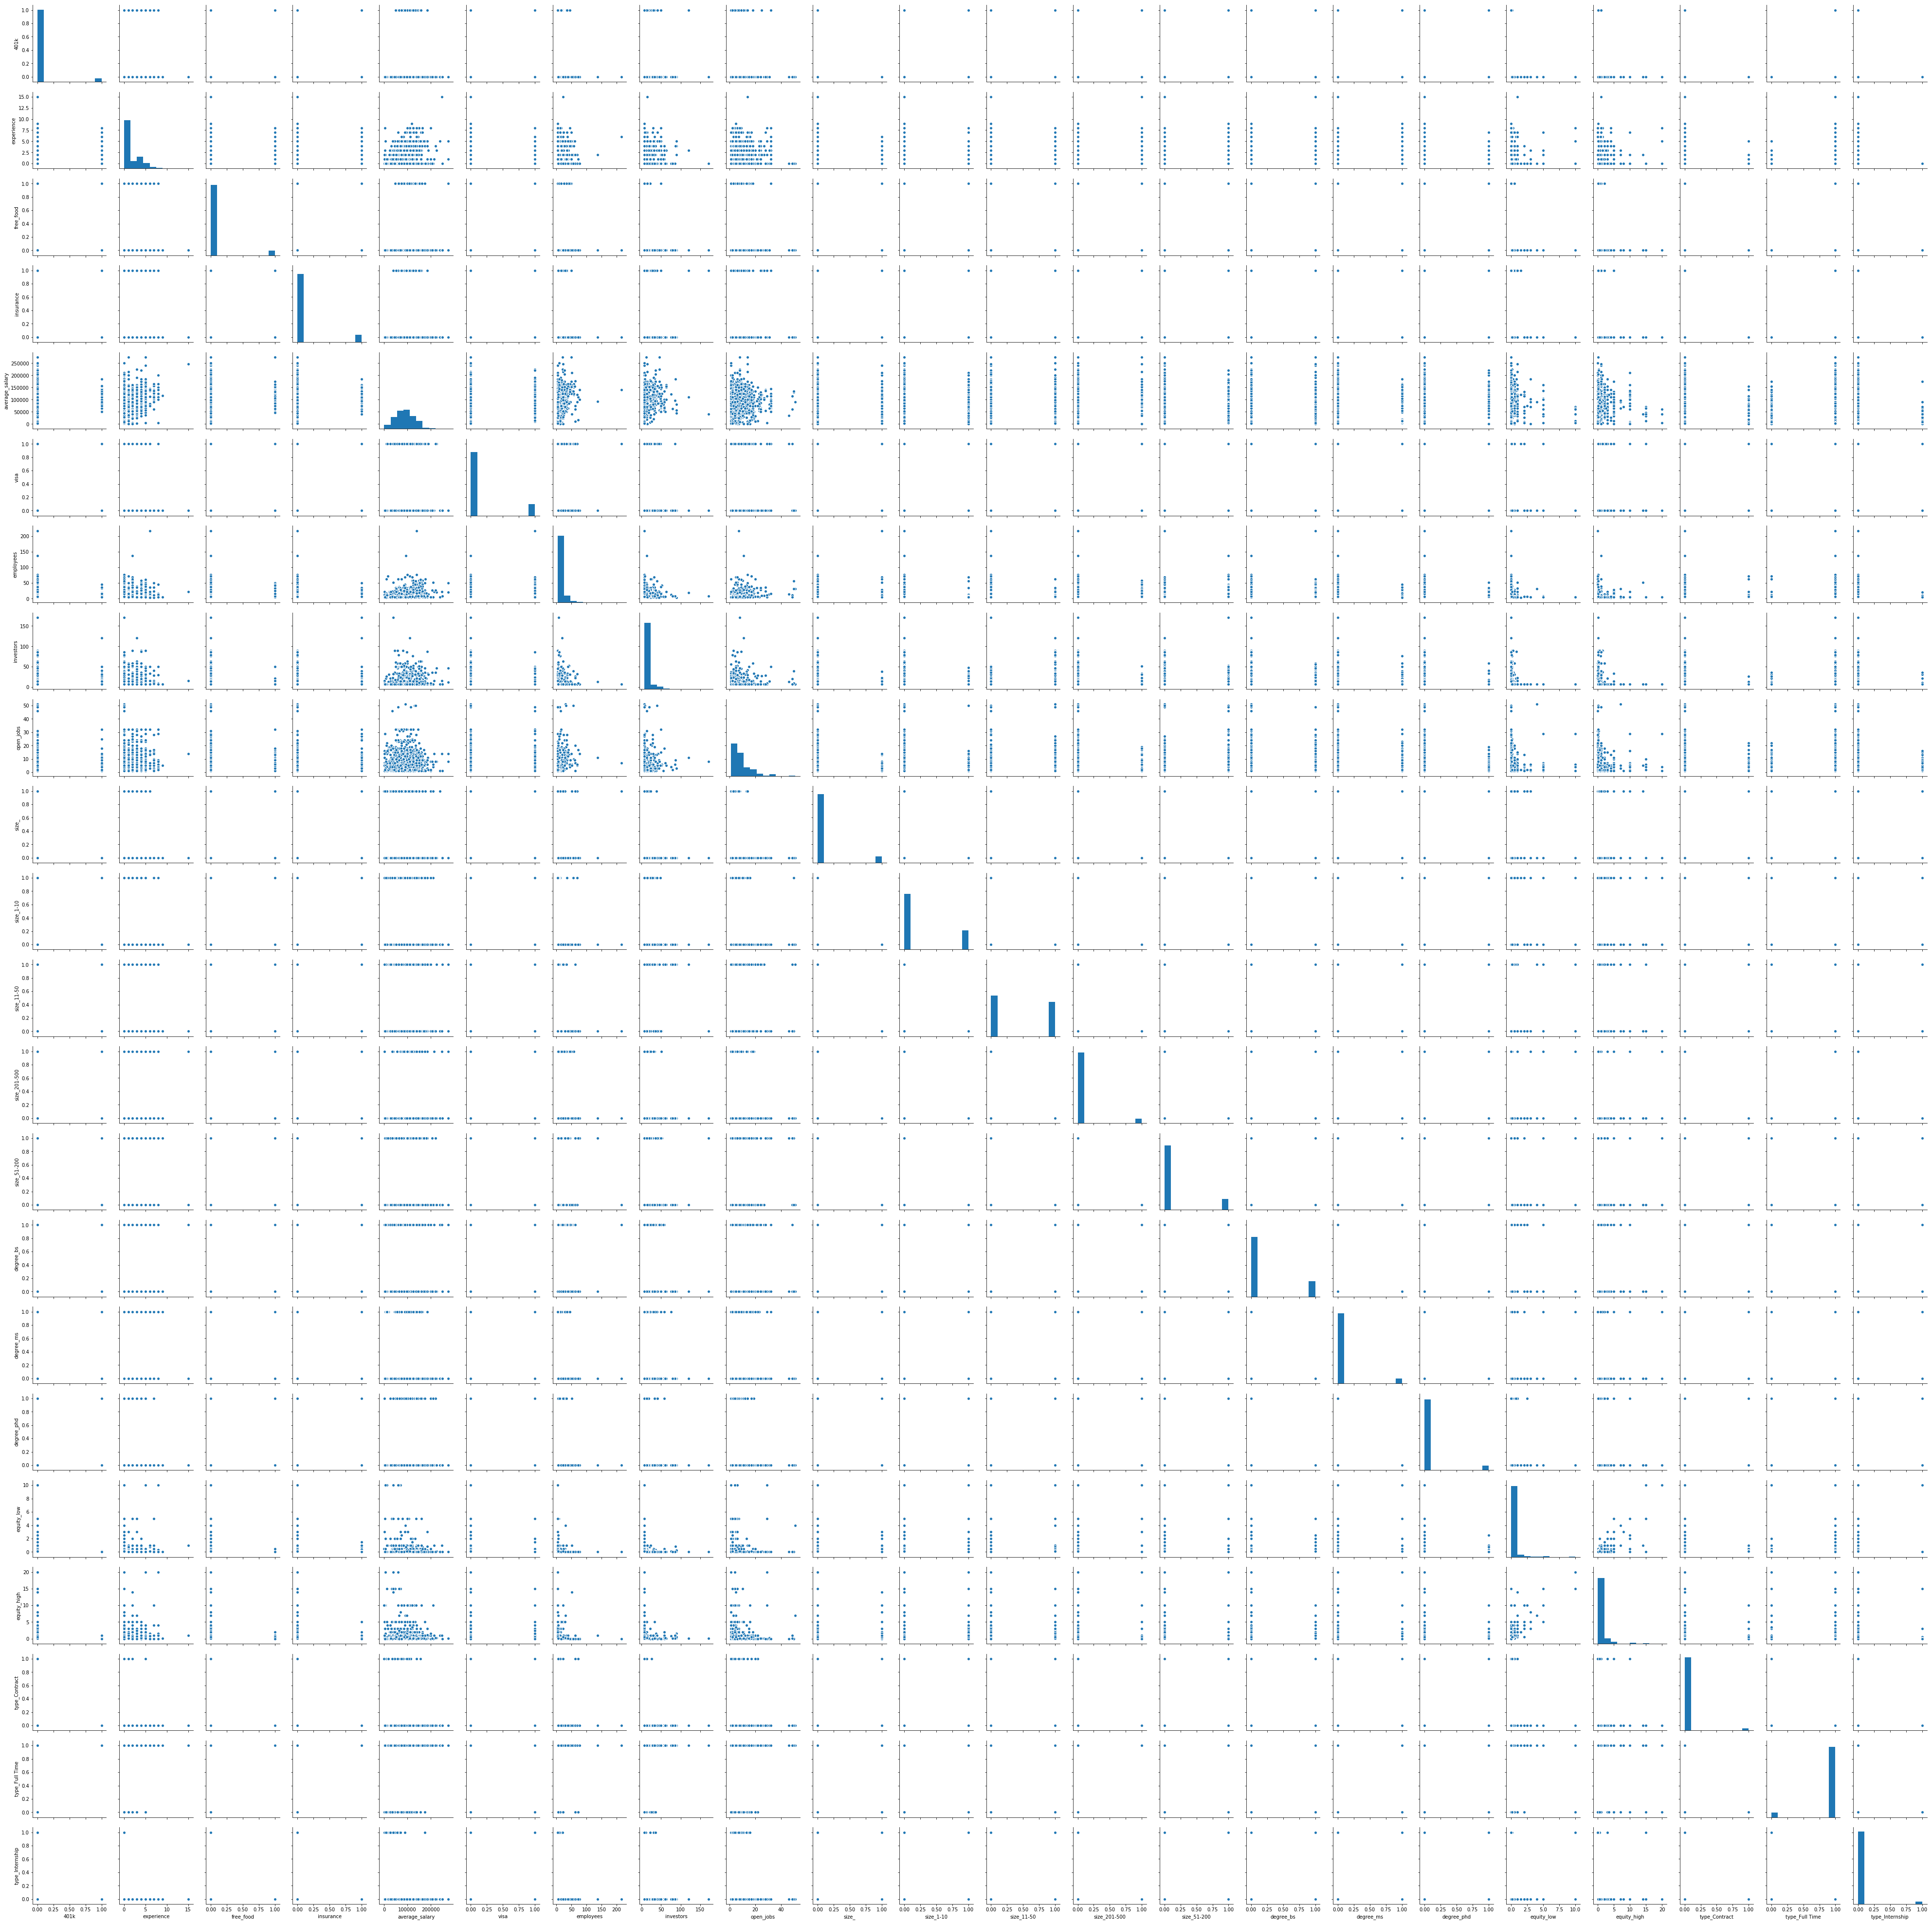

In [6]:
sns.pairplot(df4)

Prepare dataset for the model

In [ ]:
target = df4.average_salary
feature = df4.drop(columns=['average_salary','name','url_j'])

Take 15% as test set

In [ ]:
X, X_holdout, y, y_holdout = train_test_split(feature, target, test_size=0.15, random_state=42)

In [ ]:
#save the split data set and process it in the model building notebook
split_data = (X, X_holdout, y, y_holdout)
with open('split_data.pkl', 'wb') as f:
    pickle.dump(split_data,f)